In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
import numpy as np
import re

pd.set_option('display.max_columns', None)

In [2]:
# 그래프 한글화
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [3]:
df_click = pd.read_csv('../Data_file/click_stream_new.csv')
df_customer = pd.read_csv('../Data_file/customer.csv')

In [4]:
df_product = pd.read_csv('../Data_file/product.csv', on_bad_lines='skip') 
df_transaction = pd.read_csv('../Data_file/transaction_final.csv')

## 로그데이터

In [5]:
df_click.head()
df_click = df_click.sort_values(['session_id','event_time'])

In [6]:
df = df_click.copy()
df.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
469318,00001f29-3ede-4445-95f0-0178934e32ba,HOMEPAGE,2019-05-17T11:51:52.276396Z,51793173-664c-4557-8a06-fc37587bea3d,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469319,00001f29-3ede-4445-95f0-0178934e32ba,ADD_TO_CART,2019-05-17T19:54:53.276396Z,517b331c-4296-4772-a1a2-9bf7500a5570,MOBILE,33855.0,6.0,237967.0,NaN,NaN,NaN,NaN
469321,00001f29-3ede-4445-95f0-0178934e32ba,HOMEPAGE,2019-05-17T19:55:12.276396Z,2c0581d2-3185-4172-87ea-795ee26a4d0a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469322,00001f29-3ede-4445-95f0-0178934e32ba,CLICK,2019-05-18T03:58:25.276396Z,81982a1d-5562-44e8-8b1d-1c3366434c5e,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469323,00001f29-3ede-4445-95f0-0178934e32ba,CLICK,2019-05-18T12:02:44.276396Z,6f7980bf-dce4-4b1e-9ffa-5c37499c4dc7,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
click = df[['session_id','event_name','event_time','traffic_source']]
click

,session_id,event_name,event_time,traffic_source
469318,00001f29-3ede-4445-95f0-0178934e32ba,HOMEPAGE,2019-05-17T11:51:52.276396Z,MOBILE
469319,00001f29-3ede-4445-95f0-0178934e32ba,ADD_TO_CART,2019-05-17T19:54:53.276396Z,MOBILE
469321,00001f29-3ede-4445-95f0-0178934e32ba,HOMEPAGE,2019-05-17T19:55:12.276396Z,MOBILE
469322,00001f29-3ede-4445-95f0-0178934e32ba,CLICK,2019-05-18T03:58:25.276396Z,MOBILE
469323,00001f29-3ede-4445-95f0-0178934e32ba,CLICK,2019-05-18T12:02:44.276396Z,MOBILE
...,...,...,...,...
5928943,fffffaf6-55ee-428b-a3bf-075cd7f1a093,ITEM_DETAIL,2018-08-20T13:46:27.790374Z,MOBILE
5928944,fffffaf6-55ee-428b-a3bf-075cd7f1a093,ITEM_DETAIL,2018-08-22T09:00:29.790374Z,MOBILE
5928945,fffffaf6-55ee-428b-a3bf-075cd7f1a093,ITEM_DETAIL,2018-08-24T04:20:30.790374Z,MOBILE
5928946,fffffaf6-55ee-428b-a3bf-075cd7f1a093,PROMO_PAGE,2018-08-25T23:35:58.790374Z,MOBILE


## 주문데이터

In [9]:
df_t = df_transaction.copy()
df_t.drop(columns=['created_at_2','promo_yesno','booking_id'],inplace=True)
df_t['shipment_period'] = df_t['shipment_period'].apply(lambda x:x.split()[0]).astype(int)

In [10]:
# 평균접속주기를 구하기위한 코드
a = df_t.groupby('customer_id')['created_at'].unique().reset_index()
a = a.explode('created_at')
a['created_at'] = pd.to_datetime(a['created_at'])
a['purchase_period'] = a.groupby('customer_id')['created_at'].diff().dt.days+1
a = a.groupby('customer_id')['purchase_period'].mean().reset_index().round(0)
a


,customer_id,purchase_period
0,3,29.0
1,8,77.0
2,9,68.0
3,11,NaN
4,15,208.0
...,...,...
50700,99992,64.0
50701,99995,13.0
50702,99997,NaN
50703,99998,187.0


In [11]:
df_c = df_customer.copy()
df_c = df_c.drop(columns=['home_country','home_location','device_version','device_id','device_type','first_name','last_name','username','email'])
df_c = df_c.merge(df_t.groupby('customer_id')['created_at'].first().reset_index(),on='customer_id',how='right')
df_c['나이'] = pd.to_datetime('2022-08-01').year-pd.to_datetime(df_c['birthdate']).dt.year
df_c = df_c.merge(df_t.groupby('customer_id')['created_at'].last().reset_index(),on='customer_id',how='left')
df_c['최종접속경과일'] = (pd.to_datetime('2022-08-01') - pd.to_datetime(df_c['created_at_y'])).dt.days+1
df_c.drop(columns='birthdate',inplace=True)
df_c = df_c.merge(df_t.groupby('customer_id')['created_at'].count().reset_index(),on='customer_id',how='left')
df_c = df_c.merge(a,on='customer_id',how='left')
df_c.columns = ['customer_id','성별','위도','경도','가입날짜','첫주문','나이','마지막주문','최종접속경과일','총주문횟수','평균 접속 주기']
df_c['평균 접속 주기'].fillna(df_c['최종접속경과일'], inplace=True)
df_c['위험비율'] = round(df_c['최종접속경과일']/df_c['평균 접속 주기'],2)
df_c['가입후첫주문까지걸린일수'] = (pd.to_datetime(df_c['첫주문']) - pd.to_datetime(df_c['가입날짜'])).dt.days
df_c['이탈여부'] = df_c['최종접속경과일'].apply(lambda x: 1 if x>15 else 0)
df_c['성별'] = df_c['성별'].apply(lambda x: 1 if x=='M' else 0)
df_c

,customer_id,성별,위도,경도,가입날짜,첫주문,나이,마지막주문,최종접속경과일,총주문횟수,평균 접속 주기,위험비율,가입후첫주문까지걸린일수,이탈여부
0,3,1,-6.151858,106.945839,2018-08-25,2018-08-25 18:54:03,36,2022-06-26 15:41:52,36,51,29.0,1.24,0,1
1,8,0,0.970013,124.816832,2021-02-13,2021-02-13 09:47:39,22,2022-05-15 22:46:22,78,7,77.0,1.01,0,1
2,9,0,-6.035939,106.747580,2021-06-26,2021-06-27 01:51:48,16,2022-05-28 08:44:32,65,6,68.0,0.96,1,1
3,11,1,1.189610,117.064209,2022-03-06,2022-03-07 14:29:13,29,2022-03-07 14:29:13,147,1,147.0,1.00,1,1
4,15,0,-7.321196,106.653088,2019-09-28,2019-09-30 04:47:36,39,2022-01-05 06:07:58,208,5,208.0,1.00,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50700,99992,0,-4.434246,104.532857,2020-06-30,2020-06-30 21:03:37,38,2022-05-25 09:32:49,68,12,64.0,1.06,0,1
50701,99995,0,-8.196262,110.710026,2020-08-16,2020-08-19 09:50:48,17,2022-07-29 03:54:17,3,60,13.0,0.23,3,0
50702,99997,1,-8.791134,118.804722,2020-04-25,2020-04-25 18:38:16,18,2020-04-25 18:38:16,828,1,828.0,1.00,0,1
50703,99998,0,-4.092411,105.179376,2018-07-01,2018-07-02 20:56:19,8,2022-01-25 00:54:09,188,8,187.0,1.01,1,1


In [12]:
df_c.describe()

,customer_id,성별,위도,경도,나이,최종접속경과일,총주문횟수,평균 접속 주기,위험비율,가입후첫주문까지걸린일수,이탈여부
count,50705.000000,50705.000000,50705.000000,50705.000000,50705.000000,50705.000000,50705.000000,50705.000000,50705.000000,50705.000000,50705.00000
mean,49810.881353,0.358091,-5.085239,110.941290,26.525136,300.083404,16.814594,300.408914,1.052866,1.030490,0.89648
std,28957.608061,0.479444,3.098986,6.395324,7.268710,436.187183,29.711045,436.243001,0.742452,1.470339,0.30464
min,3.000000,0.000000,-10.812034,95.275319,6.000000,1.000000,1.000000,1.000000,0.030000,0.000000,0.00000
25%,24694.000000,0.000000,-7.367122,106.861050,21.000000,40.000000,2.000000,37.000000,0.970000,0.000000,1.00000
50%,49712.000000,0.000000,-6.237748,110.161505,26.000000,111.000000,6.000000,112.000000,1.000000,1.000000,1.00000
75%,74863.000000,1.000000,-3.049065,113.196497,31.000000,360.000000,18.000000,361.000000,1.000000,1.000000,1.00000
max,99999.000000,1.000000,5.818355,140.980485,68.000000,2222.000000,550.000000,2222.000000,34.000000,15.000000,1.00000


In [13]:
df_c['이탈여부'].value_counts()

이탈여부
1    45456
0     5249
Name: count, dtype: int64

In [14]:
(df_c['최종접속경과일'].value_counts(normalize=True)).sort_values(ascending=False)

최종접속경과일
1       0.010709
2       0.008106
7       0.007534
29      0.007475
28      0.007337
          ...   
1216    0.000020
1377    0.000020
1866    0.000020
1674    0.000020
2119    0.000020
Name: proportion, Length: 2062, dtype: float64

## 로지스틱회귀분석

In [82]:
logi_df = df_c[['customer_id','성별','나이','총주문횟수','평균 접속 주기','가입후첫주문까지걸린일수','이탈여부']]

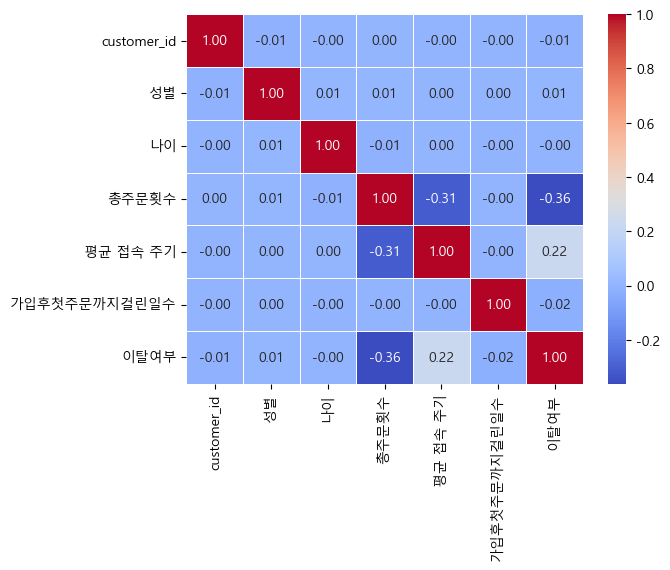

In [83]:
heatmap = sns.heatmap(logi_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

In [84]:
# train, val, test set 나누기
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, accuracy_score


# features와 label 준비 (이미 준비되어 있다고 가정)
features = logi_df.drop(columns=['customer_id','이탈여부'])
label = logi_df['이탈여부']

# 데이터를 train, test, val로 나누기
# 먼저 train과 나머지를 나누고, 나머지를 다시 test와 val로 나눕니다.
# stratify=label은 클래스 불균형을 고려하여 데이터를 분할합니다. 이것은 각 분할에서 클래스 비율을 유지하도록 합니다. 즉, 불균형한 타겟 데이터의 비율이 각 세트에서 유지됩니다.
X_train, X_temp, y_train, y_temp = train_test_split(features, label, test_size=0.4, random_state=42, stratify=label)

# 나머지를 test와 val로 나누기
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 나눈 데이터 세트의 크기 확인
print("Train 데이터 수:", len(X_train))
print("Validation 데이터 수:", len(X_val))
print("Test 데이터 수:", len(X_test))

Train 데이터 수: 30423
Validation 데이터 수: 10141
Test 데이터 수: 10141


In [85]:
#y_train의 최빈값.
# 기준모델
base_major = y_train.mode()[0]
y_pred_base = [base_major] * len(y_train)

# 기준모델의 정확도
print("training accuracy: ", accuracy_score(y_train, y_pred_base).round(2))

# 검증세트의 정확도
y_pred_base_val = [base_major] * len(y_val)
print("validation accuracy: ", accuracy_score(y_val, y_pred_base_val).round(2))

training accuracy:  0.9
validation accuracy:  0.9


In [86]:
# 로지스틱회귀는 패널티가 적용되는 정규화모델이라서 표준화필수
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [87]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

# 예측 및 정확도 확인
y_val_pred = logistic.predict(X_val)

print('logistic train accuracy', logistic.score(X_train, y_train).round(2))
print("logistic validation accuracy: ", accuracy_score(y_val, y_val_pred).round(2))

# 타켓이 불균형하기 때문에 정확도는 지표로 사용X

logistic train accuracy 0.94
logistic validation accuracy:  0.94


In [89]:
print('회귀계수가 양수인 특성 상위 3개')
print(pd.Series(logistic.coef_[0], logistic.feature_names_in_).sort_values(ascending=False).head(3), '\n')
print('회귀계수가 음수인 특성 하위 3개')
print(pd.Series(logistic.coef_[0], logistic.feature_names_in_).sort_values(ascending=False).tail(3))

회귀계수가 양수인 특성 상위 3개


AttributeError: 'LogisticRegression' object has no attribute 'feature_names_in_'

In [59]:
y_true0 = y_val.value_counts()[0]
y_true1 = y_val.value_counts()[1]
fn = len(y_pred_base_val) - y_true0
base = pd.DataFrame(index = ['True 0', 'True1'], data = {'Predicted 0':[y_true0, fn], 'Predicted 1':[0,0]})
base

,Predicted 0,Predicted 1
True 0,1050,0
True1,9091,0


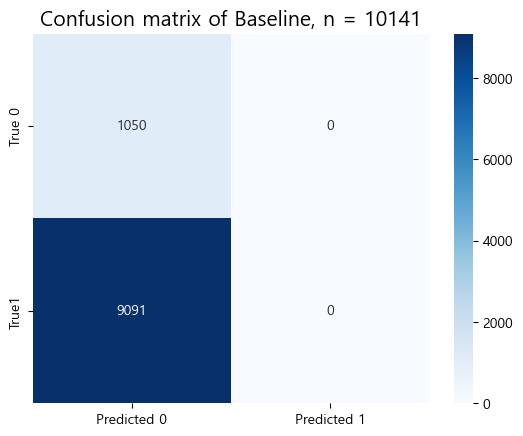

In [60]:
fig, ax = plt.subplots()
sns.heatmap(base, cmap=plt.cm.Blues, annot=True,fmt="d")
plt.title(f'Confusion matrix of Baseline, n = {len(y_val)}', fontsize=15)
plt.show()

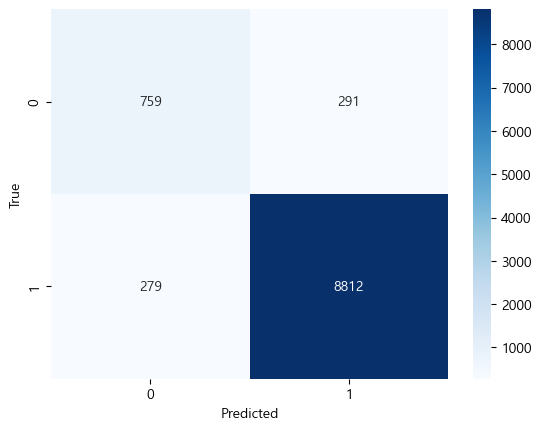

In [61]:
# 매트릭스
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val,y_val_pred), annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True');

# 왼쪽 위 (cm[0, 0]): True Negative (실제 Negative, 모델이 Negative 예측)
# 오른쪽 위 (cm[0, 1]): False Positive (실제 Negative, 모델이 Positive 예측)
# 왼쪽 아래 (cm[1, 0]): False Negative (실제 Positive, 모델이 Negative 예측)
# 오른쪽 아래 (cm[1, 1]): True Positive (실제 Positive, 모델이 Positive 예측)

In [80]:
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

print(classification_report(y_val, y_val_pred))

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f'accuracy of logistic regression is {accuracy.round(2)}')
print(f'precision of logistic regression is {precision.round(2)}')
print(f'recall of logistic regression is {recall.round(2)}')
print(f'f1 of logistic regression is {f1.round(2)}')

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1050
           1       0.97      0.97      0.97      9091

    accuracy                           0.94     10141
   macro avg       0.85      0.85      0.85     10141
weighted avg       0.94      0.94      0.94     10141

accuracy of logistic regression is 0.94
precision of logistic regression is 0.97
recall of logistic regression is 0.97
f1 of logistic regression is 0.97


True     9103
False    1038
Name: count, dtype: int64

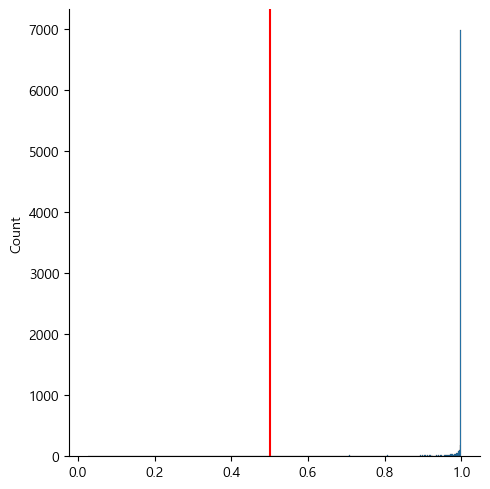

In [81]:
y_pred_proba = logistic.predict_proba(X_val)[:,1]
sns.displot(y_pred_proba)

threshold = 0.5
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1050
           1       0.97      0.97      0.97      9091

    accuracy                           0.94     10141
   macro avg       0.85      0.85      0.85     10141
weighted avg       0.94      0.94      0.94     10141



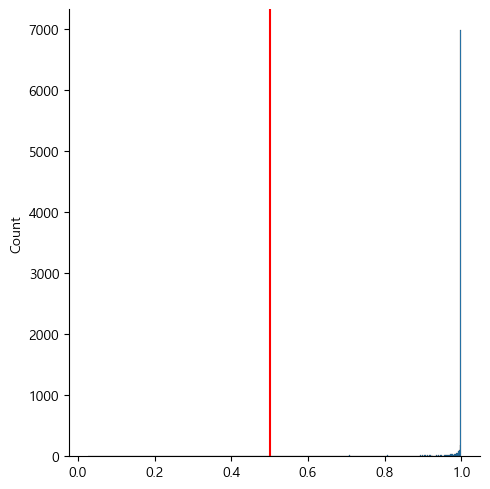

In [78]:
sns.displot(y_pred_proba)

threshold = 0.5
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

print(classification_report(y_val, y_pred))

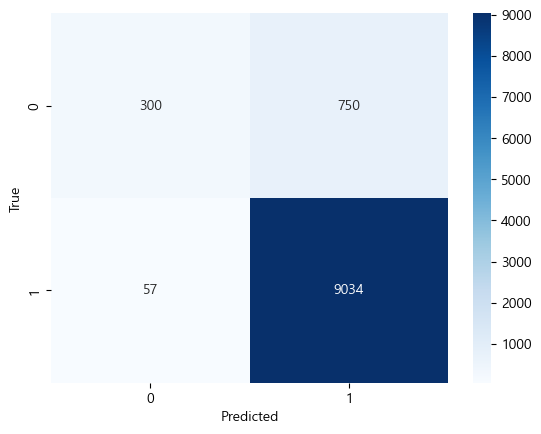

In [64]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True');

     FPR(Fall-out)  TPR(Recall)  Threshold
0         0.000000     0.000000        inf
1         0.000000     0.393356   1.000000
2         0.000000     0.399406   1.000000
3         0.000000     0.401826   1.000000
4         0.000000     0.403586   1.000000
..             ...          ...        ...
902       0.919048     0.999890   0.069605
903       0.919048     1.000000   0.069508
904       0.978095     1.000000   0.047858
905       0.980000     1.000000   0.047726
906       1.000000     1.000000   0.025402

[907 rows x 3 columns]


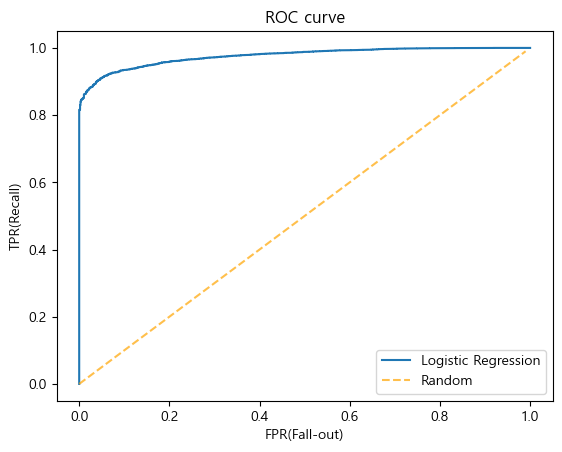

In [68]:
from sklearn.metrics import roc_curve

y_pred_proba = logistic.predict_proba(X_val)[:,1]

# roc_curve(타겟값, prob of 1)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPR(Recall)': tpr, 
    'Threshold': thresholds
})
print(roc)


plt.plot(fpr, tpr, label='Logistic Regression')
x_base = np.arange(0, 1.0, 0.01)
y_base = np.arange(0, 1.0, 0.01)
plt.plot(x_base, y_base, linestyle='--', color = 'orange', alpha=0.7, label='Random')
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.legend();


In [69]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_val, y_pred_proba)
print(f"Logistic Regression의 auc score : {auc.round(3)}")

Logistic Regression의 auc score : 0.976
